### Task One: Web scraping to gain company insights
#### Scrape and analyse customer review data to uncover findings for British Airways

In [176]:
import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup
import requests
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from nltk import ngrams
from nltk.probability import FreqDist
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
import nltk.collocations as collocations
from nltk import FreqDist , bigrams
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [12]:
# List to store all reviews
reviews = []

# List to store rating stars
stars = []

# List to store dates
date = []

# List to store countries of reviewers
country = []

In [14]:
import requests
from bs4 import BeautifulSoup

# Loop through pages 1 to 35
for i in range(1, 39):
    # Fetch the page content
    page = requests.get(f"https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100")
    
    # Parse the content with BeautifulSoup
    soup = BeautifulSoup(page.content, "html.parser")
    
    # Extract and store reviews
    for item in soup.find_all("div", class_="text_content"):
        reviews.append(item.get_text(strip=True))
    
    # Extract and store rating stars
    for item in soup.find_all("div", class_="rating-10"):
        try:
            stars.append(item.span.get_text(strip=True))
        except AttributeError:
            print(f"Error on page {i}")
            stars.append("None")
            
    # Extract and store dates
    for item in soup.find_all("time"):
        date.append(item.get_text(strip=True))
        
    # Extract and store countries
    for item in soup.find_all("h3"):
        country.append(item.span.next_sibling.get_text(strip=True).strip(" ()"))

Error on page 33
Error on page 34
Error on page 35
Error on page 37
Error on page 37


In [16]:
# Print the lengths of each extracts
print(f"Total reviews: {len(reviews)}")
stars = stars[:3800]
print(f"Total stars: {len(stars)}")
print(f"Total dates: {len(date)}")
print(f"Total countries: {len(country)}")

Total reviews: 3800
Total stars: 3800
Total dates: 3800
Total countries: 3800


In [23]:
# Create a DataFrame from the collected lists
collected_df = pd.DataFrame({
    "reviews": reviews,
    "stars": stars,
    "date": date,
    "country": country
})

In [24]:
collected_df.shape

(3800, 4)

In [25]:
collected_df.head()

,reviews,stars,date,country
0,✅Trip Verified| An excellent flight on BA City...,5,7th August 2024,Lebanon
1,✅Trip Verified| Crew were amazing and attent...,8,7th August 2024,United Kingdom
2,Not Verified| I flew internationally for the ...,10,5th August 2024,United States
3,"✅Trip Verified| BA, after subsequent delays an...",1,3rd August 2024,Italy
4,Not Verified| It is embarrassing to have the...,1,2nd August 2024,Australia


In [106]:
# Export DataFrame into a csv file
cwd = os.getcwd()
file_path = os.path.join(cwd, "British_Airways_scraped_reviews.csv")
collected_df.to_csv(file_path, index=False)

In [107]:
# Import the new csv file into a new df
unprocessed_df = pd.read_csv(file_path)

In [108]:
unprocessed_df.head()

,reviews,stars,date,country
0,✅Trip Verified| An excellent flight on BA City...,5.0,7th August 2024,Lebanon
1,✅Trip Verified| Crew were amazing and attent...,8.0,7th August 2024,United Kingdom
2,Not Verified| I flew internationally for the ...,10.0,5th August 2024,United States
3,"✅Trip Verified| BA, after subsequent delays an...",1.0,3rd August 2024,Italy
4,Not Verified| It is embarrassing to have the...,1.0,2nd August 2024,Australia


In [186]:
unprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3793 entries, 0 to 3799
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   reviews           3793 non-null   object        
 1   stars             3793 non-null   float64       
 2   date              3793 non-null   datetime64[ns]
 3   country           3793 non-null   object        
 4   verified          3793 non-null   bool          
 5   collection_words  3793 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(3)
memory usage: 181.5+ KB


In [185]:
unprocessed_df.describe()

,stars,date
count,3793.000000,3793
mean,4.684682,2017-12-27 13:21:48.832059136
min,1.000000,2014-05-11 00:00:00
25%,2.000000,2015-09-19 00:00:00
50%,4.000000,2017-03-21 00:00:00
75%,8.000000,2019-07-31 00:00:00
max,10.000000,2024-08-07 00:00:00
std,3.158392,NaN


In [111]:
# Add 'verified' column based on whether 'reviews' contains "Trip Verified"
unprocessed_df['verified'] = unprocessed_df.reviews.str.contains("Trip Verified")

In [112]:
unprocessed_df['verified']

0        True
1        True
2       False
3        True
4       False
        ...  
3795    False
3796    False
3797    False
3798    False
3799    False
Name: verified, Length: 3800, dtype: bool

In [113]:
# Initialize the WordNetLemmatizer
lemma = WordNetLemmatizer()

In [114]:
reviews_data = unprocessed_df.reviews.str.strip("✅ Trip Verified |")

In [115]:
collection_words = []

In [116]:
# Loop through each review by removing punctuation, converting to lowercase, and joining them into a single string
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    collection_words.append(rev)

In [118]:
# Add 'collection_words' column using the values from the 'collection_words' variable
unprocessed_df['collection_words'] = collection_words

In [119]:
unprocessed_df.head()

,reviews,stars,date,country,verified,collection_words
0,✅Trip Verified| An excellent flight on BA City...,5.0,7th August 2024,Lebanon,True,excellent flight ba cityflyer plane clean comf...
1,✅Trip Verified| Crew were amazing and attent...,8.0,7th August 2024,United Kingdom,True,crew amazing attentive nothing missed definite...
2,Not Verified| I flew internationally for the ...,10.0,5th August 2024,United States,False,verified flew internationally first time life ...
3,"✅Trip Verified| BA, after subsequent delays an...",1.0,3rd August 2024,Italy,True,ba subsequent delay postponed departure time i...
4,Not Verified| It is embarrassing to have the...,1.0,2nd August 2024,Australia,False,verified embarrassing word british attached ai...


In [120]:
unprocessed_df.dtypes

reviews              object
stars               float64
date                 object
country              object
verified               bool
collection_words     object
dtype: object

In [121]:
# Remove ordinal suffixes from 'date' and convert it to datetime format
unprocessed_df['date'] = unprocessed_df['date'].str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)
unprocessed_df['date'] = pd.to_datetime(unprocessed_df['date'], format='%d %B %Y')

In [122]:
unprocessed_df.date.head()

0   2024-08-07
1   2024-08-07
2   2024-08-05
3   2024-08-03
4   2024-08-02
Name: date, dtype: datetime64[ns]

In [123]:
unprocessed_df.stars.unique()

array([ 5.,  8., 10.,  1.,  3.,  6.,  9.,  2.,  7.,  4., nan])

In [129]:
# Drop rows where 'stars' column has missing values
unprocessed_df = unprocessed_df.dropna(subset=['stars'])

In [130]:
unprocessed_df.stars.unique()

array([ 5.,  8., 10.,  1.,  3.,  6.,  9.,  2.,  7.,  4.])

In [131]:
unprocessed_df.isnull().value_counts()

reviews  stars  date   country  verified  collection_words
False    False  False  False    False     False               3793
                       True     False     False                  2
Name: count, dtype: int64

In [132]:
unprocessed_df.country.isnull().value_counts()

country
False    3793
True        2
Name: count, dtype: int64

In [133]:
# Drop rows where 'country' column has missing values
unprocessed_df = unprocessed_df.dropna(subset=['country'])

In [134]:
unprocessed_df.country.isnull().value_counts()

country
False    3793
Name: count, dtype: int64

In [135]:
unprocessed_df.isnull().value_counts()

reviews  stars  date   country  verified  collection_words
False    False  False  False    False     False               3793
Name: count, dtype: int64

In [136]:
unprocessed_df.shape

(3793, 6)

In [137]:
# Reset the index of the DataFrame, dropping the old index
unprocessed_df.reset_index(drop=True)

,reviews,stars,date,country,verified,collection_words
0,✅Trip Verified| An excellent flight on BA City...,5.0,2024-08-07,Lebanon,True,excellent flight ba cityflyer plane clean comf...
1,✅Trip Verified| Crew were amazing and attent...,8.0,2024-08-07,United Kingdom,True,crew amazing attentive nothing missed definite...
2,Not Verified| I flew internationally for the ...,10.0,2024-08-05,United States,False,verified flew internationally first time life ...
3,"✅Trip Verified| BA, after subsequent delays an...",1.0,2024-08-03,Italy,True,ba subsequent delay postponed departure time i...
4,Not Verified| It is embarrassing to have the...,1.0,2024-08-02,Australia,False,verified embarrassing word british attached ai...
...,...,...,...,...,...,...
3788,I should be in a nice hotel in Romania instead...,5.0,2014-05-12,United Kingdom,False,nice hotel romania instead hour arrived heathr...
3789,LGW-MRU-LGW in business. Outbound flight good ...,1.0,2014-05-11,United Kingdom,False,lgw mru lgw business outbound flight good atte...
3790,LHR-FRA-LCY May 2014. LHR-FRA on a 767 row 18....,8.0,2014-05-11,United Kingdom,False,lhr fra lcy may lhr fra row checked via mobile...
3791,Rating : 10/10 Cabin Flown Economy Value for M...,7.0,2014-05-11,United Kingdom,False,rating cabin flown economy value money seat co...


In [138]:
# Export the cleaned DataFrame into a csv file
file_path = os.path.join(cwd, "British_Airways_cleaned_reviews.csv")
unprocessed_df.to_csv(file_path, index=False)

In [139]:
# Import the cleaned csv file into a new df
cleaned_df = pd.read_csv(file_path)

In [140]:
cleaned_df.head()

,reviews,stars,date,country,verified,collection_words
0,✅Trip Verified| An excellent flight on BA City...,5.0,2024-08-07,Lebanon,True,excellent flight ba cityflyer plane clean comf...
1,✅Trip Verified| Crew were amazing and attent...,8.0,2024-08-07,United Kingdom,True,crew amazing attentive nothing missed definite...
2,Not Verified| I flew internationally for the ...,10.0,2024-08-05,United States,False,verified flew internationally first time life ...
3,"✅Trip Verified| BA, after subsequent delays an...",1.0,2024-08-03,Italy,True,ba subsequent delay postponed departure time i...
4,Not Verified| It is embarrassing to have the...,1.0,2024-08-02,Australia,False,verified embarrassing word british attached ai...


In [141]:
cleaned_df.shape

(3793, 6)

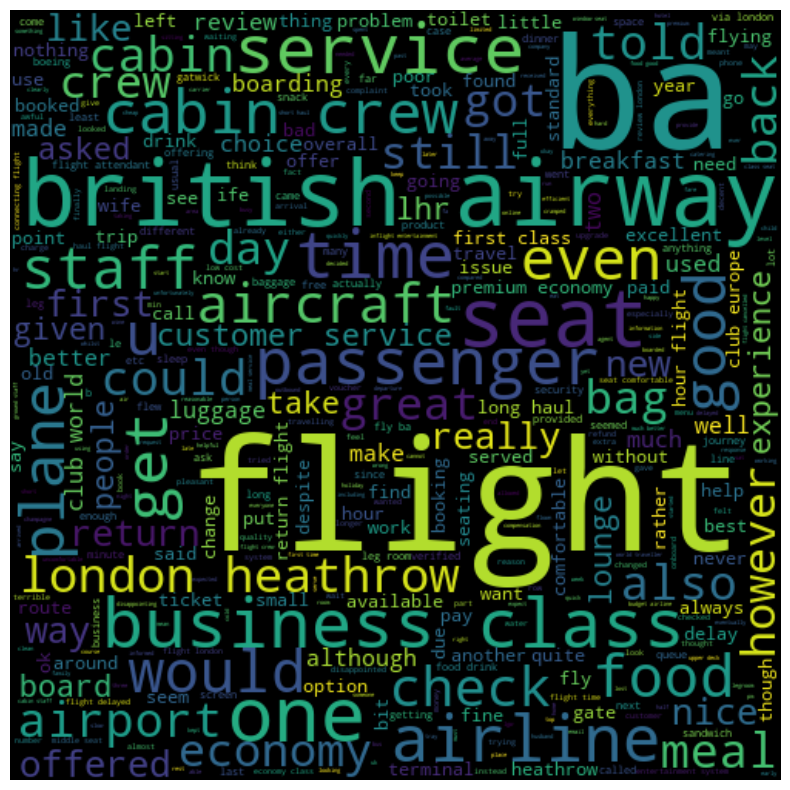

In [147]:
# Combine all the text in the 'collection_words' column into a single string
combined_reviews = " ".join(cleaned_df.collection_words)

# Set up the figure size
plt.figure(figsize=(20, 10))

# Define stopwords to exclude
excluded_stopwords = set(stopwords.words('english'))

# Generate the word cloud
wordcloud = WordCloud(
    height=500, 
    width=500, 
    max_font_size=100, 
    max_words=400, 
    stopwords=excluded_stopwords
).generate(combined_reviews)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


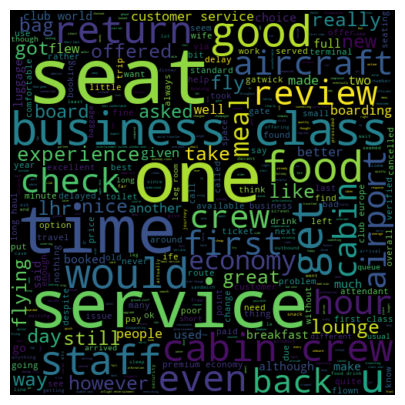

In [149]:
# Combine all the text in the 'collection_words' column into a single string
combined_reviews = " ".join(cleaned_df.collection_words)

# Set up the figure size
plt.figure(figsize=(15, 5))

# Define stopwords and update with additional custom stopwords
excluded_stopwords = set(stopwords.words('english'))
additional_stopwords = {'ba', 'british', 'airway', 'flight', 'plane', 'london', 'airline', 'also',
                        'told', 'passenger', 'could', 'heathrow'}
excluded_stopwords.update(additional_stopwords)

# Generate the word cloud
wordcloud = WordCloud(
    height=500, 
    width=500, 
    max_font_size=100, 
    max_words=400, 
    stopwords=excluded_stopwords
).generate(combined_reviews)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [157]:
# Split the combined text of all reviews into a list of words
word_list = combined_reviews.split(" ")

# Define stopwords and include additional custom stopwords
stopwords = {'ba', 'passenger', 'flight', 'u', 'london', 'airway', 'british airway',
                    'plane', 'heathrow', 'reviews'}

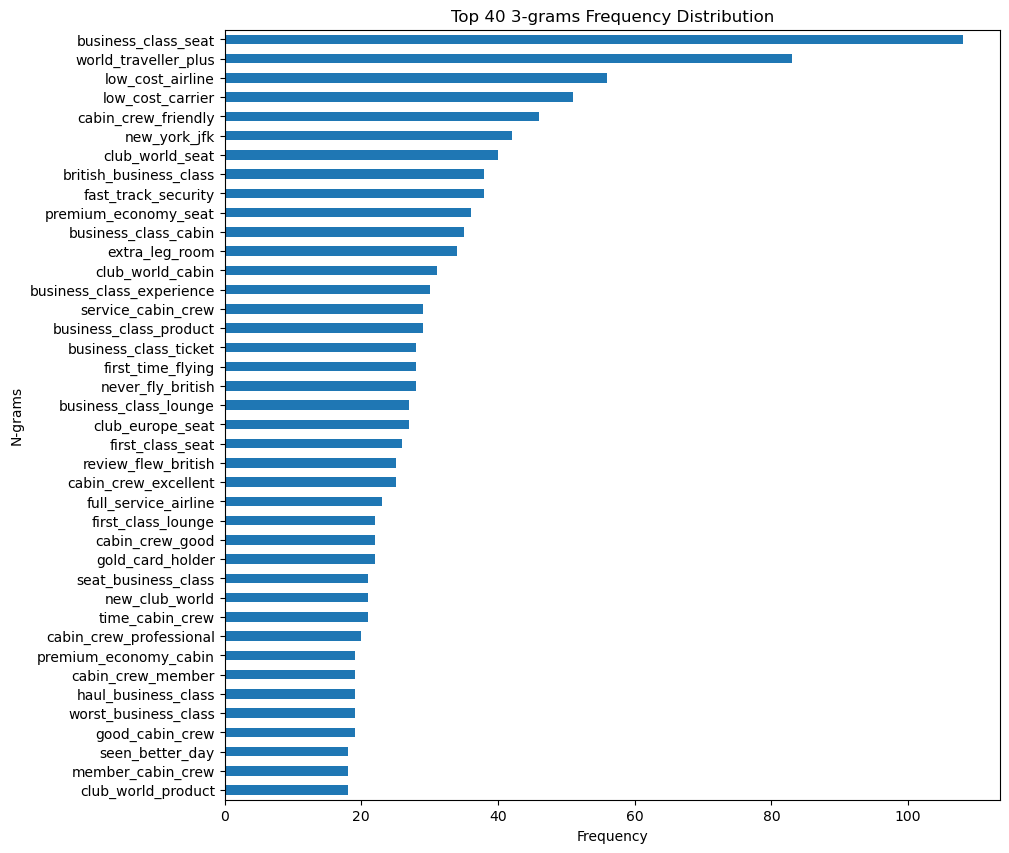

<Axes: title={'center': 'Top 40 3-grams Frequency Distribution'}, xlabel='Frequency', ylabel='N-grams'>

In [169]:
# Combine all reviews into a single string
combined_reviews = " ".join(cleaned_df.collection_words)

# Split the combined text into a list of words
word_list = combined_reviews.split(" ")

# Filter out stopwords from the list of words
filtered_words = [word for word in word_list if word not in stopwords]

def get_freq_dist(words, ngram_size):
    # Generate n-grams
    ngram_list = ngrams(words, ngram_size)

    # Create frequency distribution of n-grams
    ngram_freq_dist = FreqDist(ngram_list).most_common(40)

    # Sort n-grams by frequency
    sorted_ngrams = {k: v for k, v in sorted(ngram_freq_dist, key=lambda item: item[1], reverse=False)}

    # Join n-grams with '_' and maintain sorting
    joined_ngrams = {'_'.join(k): v for k, v in sorted_ngrams.items()}

    # Convert to pandas Series for easy plotting
    ngram_series = pd.Series(joined_ngrams)
    
    # Plot the frequency distribution
    plt.figure(figsize=(10, 10))
    ax = ngram_series.plot(kind="barh")
    plt.xlabel('Frequency')
    plt.ylabel('N-grams')
    plt.title(f'Top 40 {ngram_size}-grams Frequency Distribution')
    plt.show()

    return ax

# Generate frequency distribution for trigrams
get_freq_dist(filtered_words, 3)

In [170]:
# Filter DataFrame for different rating ranges
ratings_1_3 = cleaned_df[cleaned_df.stars.isin([1, 2, 3])]
ratings_4_6 = cleaned_df[cleaned_df.stars.isin([4, 5, 6])]
ratings_7_10 = cleaned_df[cleaned_df.stars.isin([7, 8, 9, 10])]

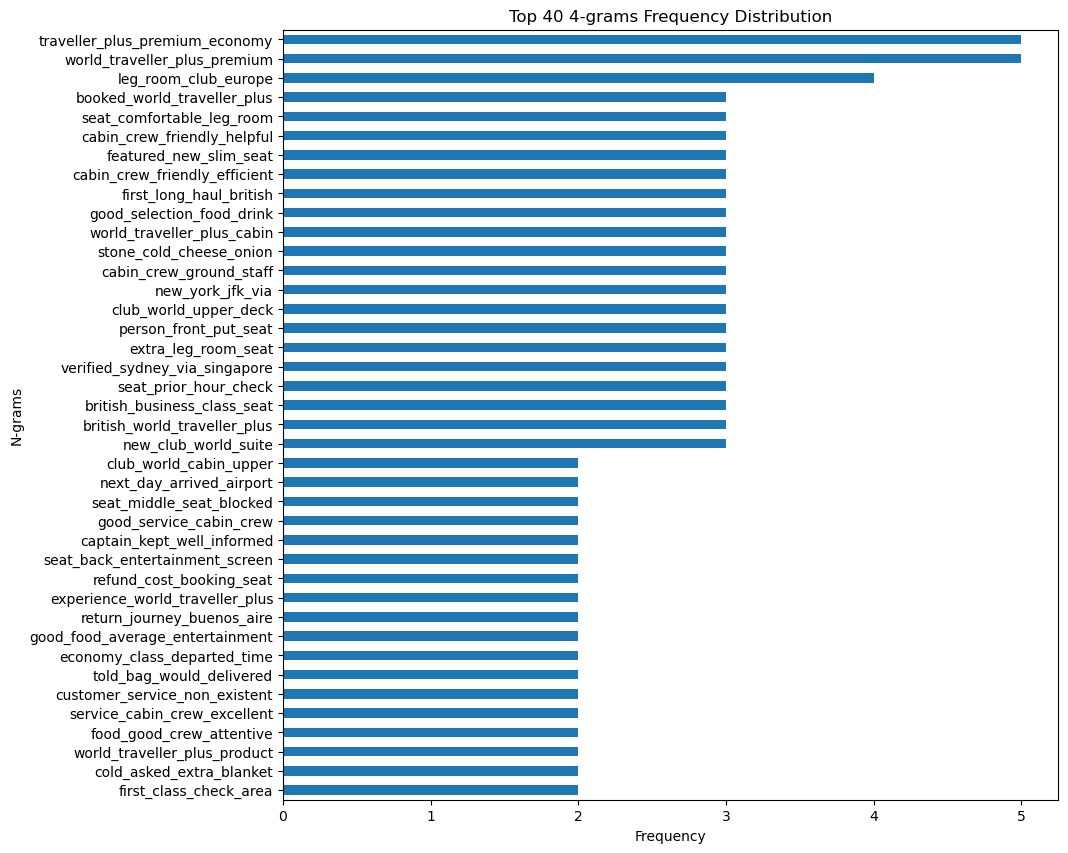

<Axes: title={'center': 'Top 40 4-grams Frequency Distribution'}, xlabel='Frequency', ylabel='N-grams'>

In [172]:
# Combine 'collection_words' from ratings 1-3, 4-6, and 7-10 into single strings
reviews_1_3 = " ".join(ratings_1_3.collection_words)
reviews_4_6 = " ".join(ratings_4_6.collection_words)
reviews_7_10 = " ".join(ratings_7_10.collection_words)

# Split the combined strings into lists of words
words_1_3 = reviews_1_3.split(" ")
words_4_6 = reviews_4_6.split(" ")
words_7_10 = reviews_7_10.split(" ")

# Remove stopwords from the list of words for ratings 7-10
new_words_7_10 = [word for word in words_7_10 if word not in stopwords]

# Get frequency distribution of the filtered words from ratings 7-10, with a threshold of 4
get_freq_dist(new_words_7_10, 4)

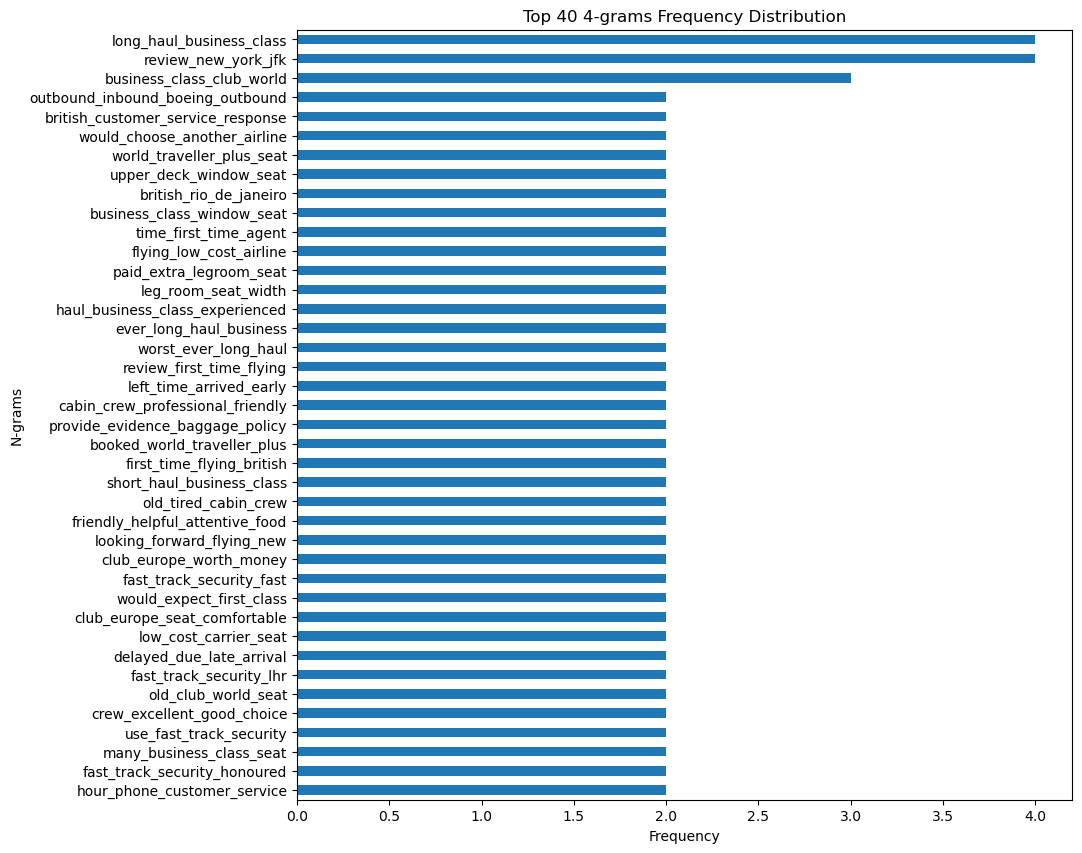

<Axes: title={'center': 'Top 40 4-grams Frequency Distribution'}, xlabel='Frequency', ylabel='N-grams'>

In [173]:
# Remove stopwords from the list of words for ratings 4-6
new_words_4_6 = [word for word in words_4_6 if word not in stopwords]

# Get frequency distribution of the filtered words from ratings 4-6, with a threshold of 4
get_freq_dist(new_words_4_6, 4)


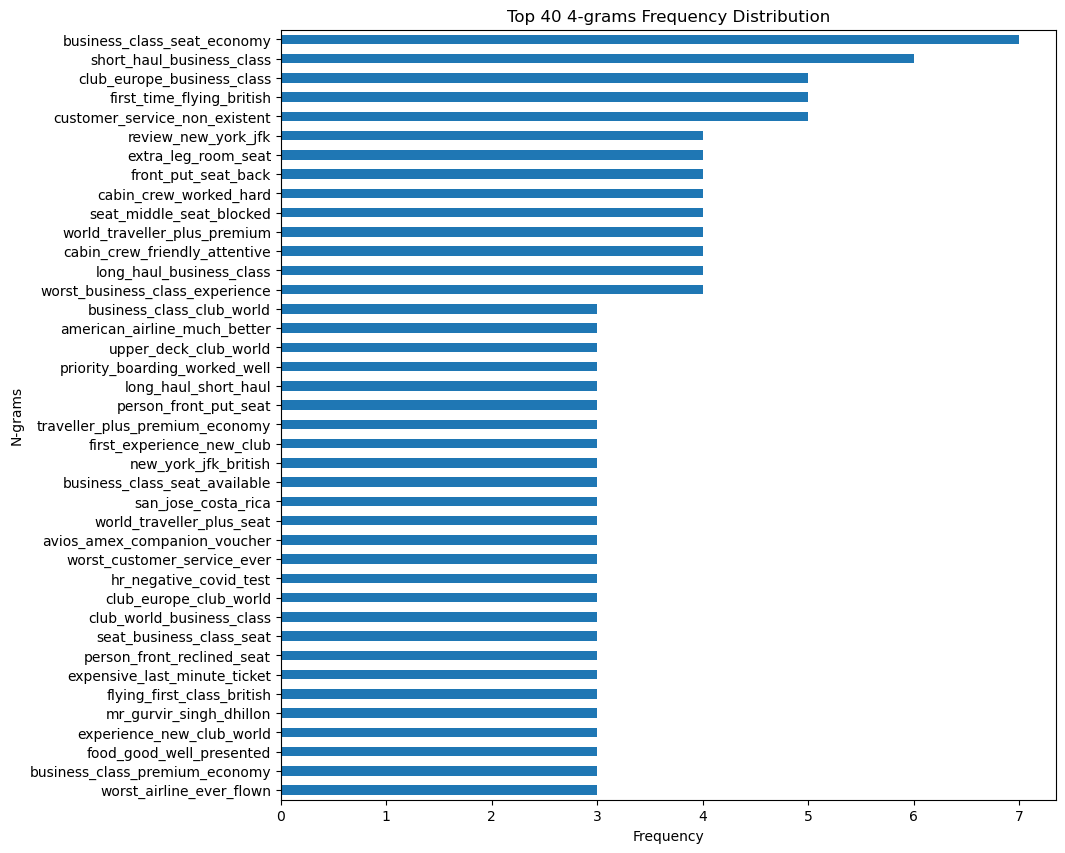

<Axes: title={'center': 'Top 40 4-grams Frequency Distribution'}, xlabel='Frequency', ylabel='N-grams'>

In [174]:
# Remove stopwords from the list of words for ratings 1-3
new_words_1_3 = [word for word in words_1_3 if word not in stopwords]

# Get frequency distribution of the filtered words from ratings 1-3, with a threshold of 4
get_freq_dist(new_words_1_3, 4)


In [177]:
# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate VADER sentiment
def vadersentimentanalysis(review):
    sentiment_scores = analyzer.polarity_scores(review)
    return sentiment_scores['compound']

# Apply the sentiment analysis to the 'reviews' column
cleaned_df['Sentiment'] = cleaned_df['reviews'].apply(vadersentimentanalysis)

# Function to categorize sentiment based on compound score
def vader_analysis(compound_score):
    if compound_score >= 0.5:
        return 'Positive'
    elif compound_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment categorization to the 'Sentiment' column
cleaned_df['Analysis'] = cleaned_df['Sentiment'].apply(vader_analysis)

# Display the first few rows of the DataFrame
cleaned_df.head()

,reviews,stars,date,country,verified,collection_words,Sentiment,Analysis
0,✅Trip Verified| An excellent flight on BA City...,5.0,2024-08-07,Lebanon,True,excellent flight ba cityflyer plane clean comf...,0.9888,Positive
1,✅Trip Verified| Crew were amazing and attent...,8.0,2024-08-07,United Kingdom,True,crew amazing attentive nothing missed definite...,0.9402,Positive
2,Not Verified| I flew internationally for the ...,10.0,2024-08-05,United States,False,verified flew internationally first time life ...,-0.8243,Negative
3,"✅Trip Verified| BA, after subsequent delays an...",1.0,2024-08-03,Italy,True,ba subsequent delay postponed departure time i...,-0.9884,Negative
4,Not Verified| It is embarrassing to have the...,1.0,2024-08-02,Australia,False,verified embarrassing word british attached ai...,-0.4525,Negative


In [178]:
# Count occurrences of each sentiment in the 'Analysis' column
vader_counts = cleaned_df['Analysis'].value_counts()

# Display the count of each sentiment
vader_counts

Analysis
Positive    1850
Negative    1604
Neutral      339
Name: count, dtype: int64

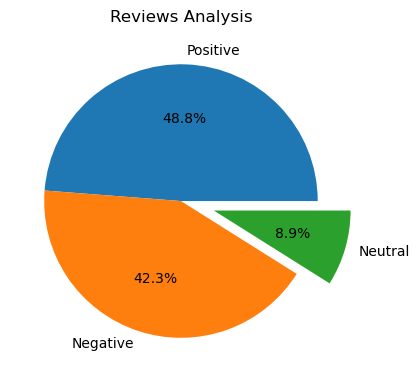

In [180]:
# Ensure matplotlib plots inline in Jupyter notebooks
%matplotlib inline

# Create a figure with a specific size
plt.figure(figsize=(15, 7))

# Create a pie chart for sentiment analysis
plt.subplot(1, 3, 2)  # Define the position of the subplot
plt.title("Reviews Analysis")

# Create the pie chart
plt.pie(
    vader_counts.values,
    labels=vader_counts.index,
    explode=(0, 0, 0.25),
    autopct='%1.1f%%',
    shadow=False
)

# Show the plot
plt.show()

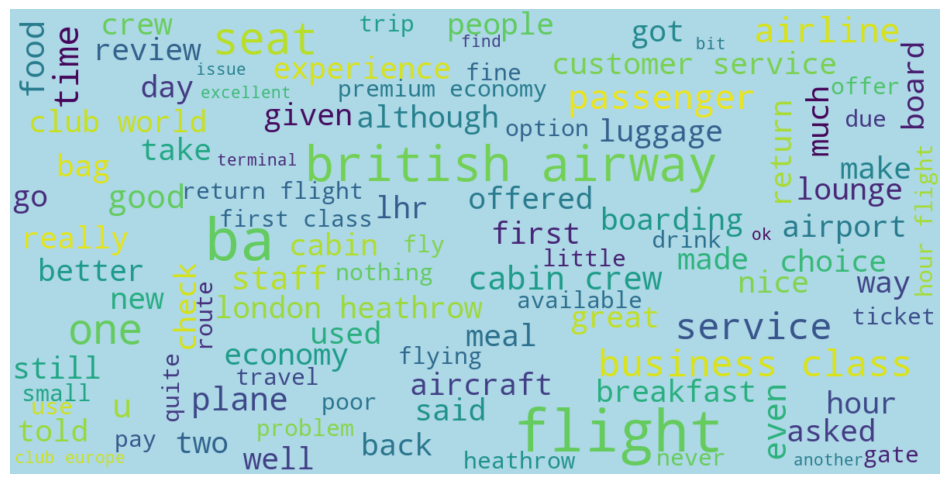

In [183]:
# Define stopwords for the word cloud
stopwords = set(STOPWORDS)

# Function to generate and display a word cloud
def show_wordcloud(data):
    # Create a WordCloud object with specified parameters
    wordcloud = WordCloud(
        background_color='lightblue',
        stopwords=stopwords,
        max_words=100,
        max_font_size=25,
        scale=3,
        random_state=1
    )

    # Generate the word cloud from the provided text data
    wordcloud.generate(str(data))

    # Create a figure for the word cloud plot
    plt.figure(figsize=(12, 12))
    plt.axis('off')  # Turn off the axis

    # Display the word cloud image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

# Show the word cloud for the text in the DataFrame
show_wordcloud(" ".join(cleaned_df['collection_words']))

In [184]:
# Export the analysed DataFrame into a csv file
file_path = os.path.join(cwd, "British_Airways_reviews.csv")
unprocessed_df.to_csv(file_path, index=False)